## **State Schema**

In [12]:
import warnings
warnings.filterwarnings("ignore")

from dataclasses import dataclass
import random
from langgraph.graph import StateGraph, END
from IPython.display import display, Image
from typing import TypedDict, Literal

### **TypedDict**
With `Literal["happy.","sad."]` in the schema, I dont need to pass `"mood"` in `graph.invoke()`

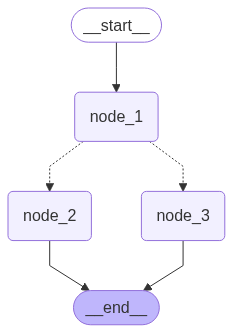

In [72]:
class State(TypedDict):
    name: str
    mood: Literal["happy.","sad."]


def node_1(state):
    print ("--- Node 1 ---")
    return {"name": state['name'] + " is "}

def node_2(state):
    print ("--- Node 2 ---")
    return {"mood": "happy."}

def node_3(state):
    print ("--- Node 3 ---")
    return {"mood": "sad."}

def moodDecide(state):
    return random.choice(["node_2", "node_3"])


builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

builder.set_entry_point("node_1")
builder.add_conditional_edges(
    "node_1",
    moodDecide,
    {
        "node_2": "node_2",
        "node_3": "node_3"
    }
)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)


graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [73]:
graph.invoke({"name": "Khoa"})

--- Node 1 ---
--- Node 3 ---


{'name': 'Khoa is ', 'mood': 'sad.'}

### **Dataclass**
Python's [dataclasses](https://docs.python.org/3/library/dataclasses.html) provide [another way to define structured data](https://www.datacamp.com/tutorial/python-data-classes).

Dataclasses offer a concise syntax for creating classes that are primarily used to store data.

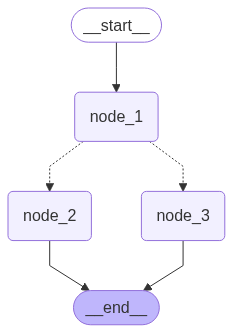

In [76]:
@dataclass
class dataClass_State:
    name: str
    mood: str


def node_1(state):
    print ("--- Node 1 ---")
    return {"name": state.name + " is "}


builder = StateGraph(dataClass_State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

builder.set_entry_point("node_1")
builder.add_conditional_edges(
    "node_1",
    moodDecide,
    {
        "node_2": "node_2",
        "node_3": "node_3"
    }
)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)


graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [27]:
graph.invoke({"name": "Khoa", "mood": "misses her"})

--- Node 1 ---
--- Node 3 ---


{'name': 'sad.', 'mood': 'misses her'}

### **Pydantic**
As mentioned, `TypedDict` and `dataclasses` provide type hints but they don't enforce types at runtime. 
 
This means you could potentially assign invalid values without raising an error!

For example, we can set `mood` to `mad` even though our type hint specifies `mood: list[Literal["happy","sad"]]`.

In [29]:
dataclass_instance = dataClass_State(name = "Lance", mood = "mad")

[Pydantic](https://docs.pydantic.dev/latest/api/base_model/) is a data validation and settings management library using Python type annotations. 

Pydantic can perform validation to check whether data conforms to the specified types and constraints at runtime.

In [65]:
from pydantic import BaseModel, field_validator, ValidationError

class pydantic_State(BaseModel):
    name: str
    mood: str # "happy" or "sad" 

    @field_validator('mood')

    # `self` doesn't exist yet because the object isn't created.
    # Use @classmethod to get cls (class) during validation.
    @classmethod
    def validate_mood(cls, value):
        # Ensure the mood is either "happy" or "sad"
        if value not in ["happy.", "sad."]:
            raise ValueError("Each mood must be either 'happy.' or 'sad.'")
        return value

try:
    state = pydantic_State(name = "John Doe", mood = "mad")
except ValidationError as e:
    print("Validation Error:", e)

Validation Error: 1 validation error for pydantic_State
mood
  Value error, Each mood must be either 'happy.' or 'sad.' [type=value_error, input_value='mad', input_type=str]
    For further information visit https://errors.pydantic.dev/2.11/v/value_error


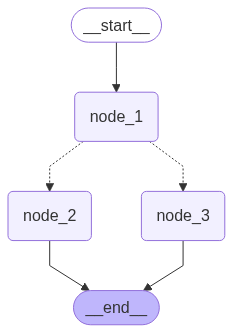

In [77]:
builder = StateGraph(pydantic_State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

builder.set_entry_point("node_1")
builder.add_conditional_edges(
    "node_1",
    moodDecide,
    {
        "node_2": "node_2",
        "node_3": "node_3"
    }
)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [82]:
graph.invoke(pydantic_State(name = "Lance", mood = "sad."))

--- Node 1 ---
--- Node 3 ---


{'name': 'Lance is ', 'mood': 'sad.'}

## **State Reducers**

In [ ]:
import warnings
warnings.filterwarnings("ignore")

from typing import TypedDict
from langgraph.graph import StateGraph, END
from typing_extensions import Annotated
from langchain_core.messages import AnyMessage, HumanMessage, AIMessage
from langgraph.graph.message import add_messages
from operator import add
from IPython.display import display, Image

### **Branch**

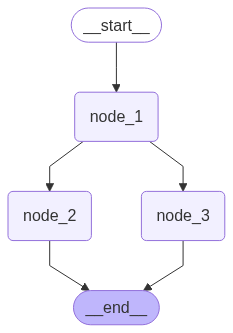

In [ ]:
class State(TypedDict):
    messages: str


def node_1(state):
    print("---Node 1---")
    return {"messages": "List of emotion: "}

def node_2(state):
    print("---Node 2---")
    return {"messages": state['messages'][-1] + "happy, "}

def node_3(state):
    print("---Node 3---")
    return {"messages": state['messages'][-1] + "sad, "}


builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

builder.set_entry_point("node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_1", "node_3")
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)


graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [88]:
from langgraph.errors import InvalidUpdateError

try:
    graph.invoke({"messages" : ""})
except InvalidUpdateError as e:
    print(f"InvalidUpdateError occurred: {e}")

---Node 1---
---Node 2---
---Node 3---
InvalidUpdateError occurred: At key 'messages': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE


### **Reducers**

[Reducers](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) give us a general way to address this problem.

We can use the `Annotated` type to specify a reducer function. 

When `operator.add` is applied to lists, it performs list concatenation.

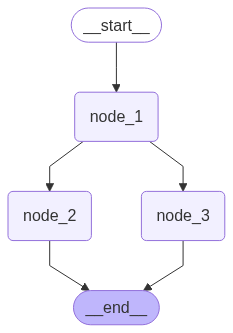

In [95]:
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages, add]


def node_1(state):
    print("---Node 1---")
    return {"messages": [HumanMessage(content = "List of emotion: ")]}

def node_2(state):
    print("---Node 2---")
    last_msg = state['messages'][-1].content
    return {"messages": [HumanMessage(content = last_msg + "happy, ")]}

def node_3(state):
    print("---Node 3---")
    last_msg = state['messages'][-1].content
    return {"messages": [HumanMessage(content = last_msg + "sad, ")]}



builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

builder.set_entry_point("node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_1", "node_3")
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)


graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [96]:
graph.invoke({"messages": [HumanMessage(content = "", name = "Khoa")]})

---Node 1---
---Node 2---
---Node 3---


{'messages': [HumanMessage(content='', additional_kwargs={}, response_metadata={}, name='Khoa'),
  HumanMessage(content='List of emotion: ', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='List of emotion: happy, ', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='List of emotion: sad, ', additional_kwargs={}, response_metadata={})]}

### **Custom Reducers**

In [97]:
def reduce_list(left: list | None, right: list | None) -> list:
    """Safely combine two lists, handling cases where either or both inputs might be None.

    Args:
        left (list | None): The first list to combine, or None.
        right (list | None): The second list to combine, or None.

    Returns:
        list: A new list containing all elements from both input lists.
               If an input is None, it's treated as an empty list.
    """
    if not left:
        left = []
    if not right:
        right = []
    return left + right

class DefaultState(TypedDict):
    foo: Annotated[list[int], add]

class CustomReducerState(TypedDict):
    foo: Annotated[list[int], reduce_list]

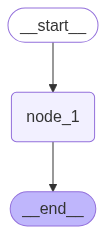

TypeError occurred: can only concatenate list (not "NoneType") to list


In [ ]:
def node_1(state):
    print("---Node 1---")
    return {"foo": [2]}


builder = StateGraph(DefaultState)
builder.add_node("node_1", node_1)

builder.set_entry_point("node_1")
builder.add_edge("node_1", END)


graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))


try:
    print(graph.invoke({"foo" : None}))
except TypeError as e:
    print(f"TypeError occurred: {e}")

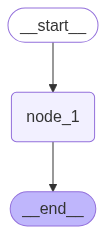

---Node 1---
{'foo': [2]}


In [101]:
builder = StateGraph(CustomReducerState)
builder.add_node("node_1", node_1)

builder.set_entry_point("node_1")
builder.add_edge("node_1", END)


graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))


try:
    print(graph.invoke({"foo" : None}))
except TypeError as e:
    print(f"TypeError occurred: {e}")

### **Re-writing**

In [103]:
messages = [
    AIMessage(content = "Hello! How can I assist you?", name = "Model", id = "1"),
    HumanMessage(content="I'm looking for information on marine biology.", name = "Lance", id = "2")
]

text = HumanMessage(content = "I'm looking for information on whales, specifically", name = "Lance", id = "2")
add_messages(messages, text)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='1'),
 HumanMessage(content="I'm looking for information on whales, specifically", additional_kwargs={}, response_metadata={}, name='Lance', id='2')]

### **Removal**

In [112]:
from langchain_core.messages import RemoveMessage

messages = [AIMessage("Hi.", name = "Bot", id = "1")]
messages.append(HumanMessage("Hi.", name = "Lance", id = "2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name = "Bot", id = "3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name = "Lance", id = "1"))

delete_messages = [RemoveMessage(id = m.id) for m in messages[:-2]]
print(delete_messages, '\n' * 2, messages)

add_messages(messages , delete_messages)

[RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='1'), RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='2')] 

 [AIMessage(content='Hi.', additional_kwargs={}, response_metadata={}, name='Bot', id='1'), HumanMessage(content='Hi.', additional_kwargs={}, response_metadata={}, name='Lance', id='2'), AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Bot', id='3'), HumanMessage(content='Yes, I know about whales. But what others should I learn about?', additional_kwargs={}, response_metadata={}, name='Lance', id='1')]


[AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Bot', id='3')]